# Transfer Learning with Pytorch

This notebook showcases how to perform transfer learning with pytorch.
Two sections are provided:
1. Training: pre-trained DenseNet121 model is loaded and trained with a reduced Cats & Dogs dataset after re-organizing it.
2. Inference: saved trained model is used to perform inference.

## 1. Training

First, the dataset needs to be re-organized in a `train/` forlder with a subfolder for each class. This is done with the script `organize_dataset.py`. As example, the reduced dataset in `../data/cat_dog_small/` is used, only with 25 cat and 25 dog images (the dataset is originally from Kaggle).

Before any training or going through this notebook, we should delete the folders `../data/cat_dog_small/train` and `../data/cat_dog_small/test`, and keep only `../data/cat_dog_small/all`.

### 1.1 Dataset: prepare and load

In [1]:
# Various modules: OpenCV, organize_dataset, matplotlib, utils
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import random
import math
import pandas as pd
import organize_dataset
%matplotlib inline
# PyTorch modules: Deep Learning
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
# Pre-trained networks are in models
from torchvision import datasets, transforms, models

In [2]:
# Move sample files to their class folders in train/
dataset_dir = '../data/cat_dog_small/all'
annotations = '../data/cat_dog_small/cat_dog_small_annotations.xlsx'
class_names = ['Cat','Dog']
num_images = -1
organize_dataset.reorganize_samples(dataset_dir = dataset_dir, annotations = annotations, num_samples = num_images)

Samples in each class:  [25, 25]


In [3]:
# Create train/ and test/ splits
fraction = 0.3
trainpath = '../data/cat_dog_small/train'
testpath = '../data/cat_dog_small/test'
organize_dataset.split_dataset(trainpath = trainpath, fraction = fraction)

Moving 7 / 25 files from ../data/cat_dog_small/train/Cat to ../data/cat_dog_small/test/Cat
Moving 7 / 25 files from ../data/cat_dog_small/train/Dog to ../data/cat_dog_small/test/Dog


'../data/cat_dog_small/test'

Image number 5
Image shape: (499, 499, 3)


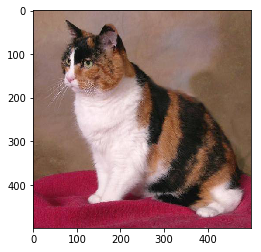

In [4]:
# Visualize one image
imagefiles = []
path = '../data/cat_dog_small/train/Cat'
for (dirpath, dirnames, filenames) in os.walk(path):
    imagefiles.extend(filenames)
    break
#index = 2
index = math.ceil(random.random()*len(imagefiles))
image = cv2.imread(path + '/' + imagefiles[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print('Image number {}'.format(index))
print('Image shape: {}'.format(image.shape))

In [5]:
# If transfer-learning is used we need to adapt our dataset
# to how the pre-trained networks were trained. That means usually:
# resizeíng to 224x224 & scaling each channel independently:
# mean = [0.485, 0.456], std = [0.229, 0.224, 0.225] 
# Training data with augmentation (recommended)
train_transforms = transforms.Compose([
                                       #transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       #transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
# Test data without augmentation
test_transforms = transforms.Compose([ transforms.Resize(230),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(trainpath, transform=train_transforms)
test_data = datasets.ImageFolder(testpath, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True)

### 1.2 Network: load and prepare

In [6]:
# Load pre-trained model, eg DenseNet (number means layers - more usually better)
# Last layer is a classifier - we're going to replace it
model = models.densenet121(pretrained=True)
#model = models.resnet50(pretrained=True)
# Display model to check sizes (in_features) last layer: classifier
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
# Freeze parameters of the pre-trained network so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
# Define our own last classifier layers
# Our inputs must match with the ones in the pre-trained network (in_features)
intermediate_size = 500
#output_size = 2
output_size = len(class_names)
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, intermediate_size)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(intermediate_size, output_size)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
# Replace classifier
model.classifier = classifier

In [8]:
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# Detect whether we can work on CUDA GPU - otherwise, CPU
# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device: 
# input = data.to(device)
# model = MyModule(...).to(device)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # due to some reason I don't know, it doesn't work on GPU/CUDA
print('Device: {}'.format(device))

Device: cpu


### 1.3 Train

In [9]:
# TEST: Accuracy measurement
def check_accuracy(model, dataloader, device, ratio=0.5, verbose=False):
    correct = 0
    total = 0
    # Change model to device - cuda if available
    model.to(device)
    with torch.no_grad():
        total_num_batches = len(dataloader)
        max_num_batches = math.floor(ratio*total_num_batches)
        b = 0
        for data in dataloader:
            images, labels = data
            # Change images & labels to device - cuda if available
            # NOTE: no resizing done, because the architecture does not require it
            # Always check the input size of the architecture (particularly in transfer learning)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            b += 1
            if b>max_num_batches:
                break
    accuracy = correct / total
    if (verbose):
        print('Accuracy of the network on {} test images: {a:2.1f} %'.format(total, a=100 * accuracy))
    return accuracy

In [10]:
# TRAINING
def train_model(model, optimizer, criterion, trainloader, testloader, device, num_epochs=3, print_every=4, do_validation=False):
    #epochs = 3
    #print_every = 4
    epochs = num_epochs
    print_every = print_every
    steps = 0
    # Change model to device - cuda if available
    model.to(device)
    model.train()
    loss_values = []
    accuracy_values = []
    for e in range(epochs):
        running_loss = 0
        for i, (images, labels) in enumerate(trainloader):
            steps += 1        
            # Change images & labels to device - cuda if available
            # NOTE: no resizing done, because the architecture does not require it
            # Always check the input size of the architecture (particularly in transfer learning)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Forward and backward passes
            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            #loss.requires_grad = True
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % print_every == 0:
                running_loss = running_loss/print_every
                loss_values.append(running_loss)
                if (do_validation):
                    accuracy = check_accuracy(model, dataloader=testloader, device=device, ratio = 0.5, verbose=False)
                    accuracy_values.append(accuracy)
                    print("Epoch: {}/{}... ".format(e+1, epochs),
                          "Loss: {:.4f}".format(running_loss),
                          ", Accuracy: {:.4f}".format(accuracy))
                else:
                    print("Epoch: {}/{}... ".format(e+1, epochs),
                          "Loss: {:.4f}".format(running_loss))                    
                # reset
                running_loss = 0
    print('Finished training!')
    return loss_values, accuracy_values

In [11]:
loss_values, accuracy_values = train_model(model,
                                           optimizer=optimizer,
                                           criterion=criterion,
                                           trainloader=trainloader,
                                           testloader=testloader,
                                           device=device,
                                           num_epochs=2,
                                           print_every=4,
                                           do_validation=True)

Epoch: 1/2...  Loss: 1.0143 , Accuracy: 0.5000
Epoch: 1/2...  Loss: 0.9738 , Accuracy: 0.9167
Epoch: 2/2...  Loss: 0.4086 , Accuracy: 0.6667
Epoch: 2/2...  Loss: 0.8330 , Accuracy: 0.8333
Finished training!


### 1.4 Visualize training results

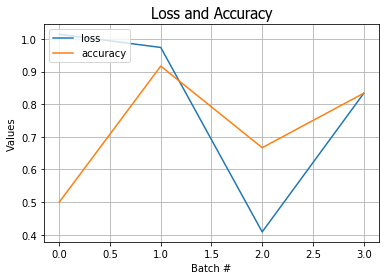

In [15]:
# Plot loss and accuracy diagrams
x = np.arange(len(loss_values))
plt.plot(x, loss_values, x, accuracy_values)
plt.xlabel('Batch #')
plt.ylabel('Values')
plt.title('Loss and Accuracy', fontname = 'Tahoma', fontsize = 15)
plt.legend(('loss', 'accuracy'), loc = 'upper left')
plt.grid(True)
plt.savefig('./training_diagram.pdf')
plt.savefig('./training_diagram.png')
plt.show()

In [16]:
def visualize_classify(model, dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))
    normalize = True

    with torch.no_grad():
        dataiter = iter(dataloader)
        inputs, labels = dataiter.next()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model.forward(inputs)
        _, preds = torch.max(outputs.data, dim=1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}, true: {}'.format(class_names[preds[j]],class_names[labels[j]]))
            image = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
            if normalize:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = std * image + mean
                image = np.clip(image, 0, 1)        
            plt.imshow(image)
            if images_so_far == num_images:
                model.train(mode=was_training)
                break
        model.train(mode=was_training)

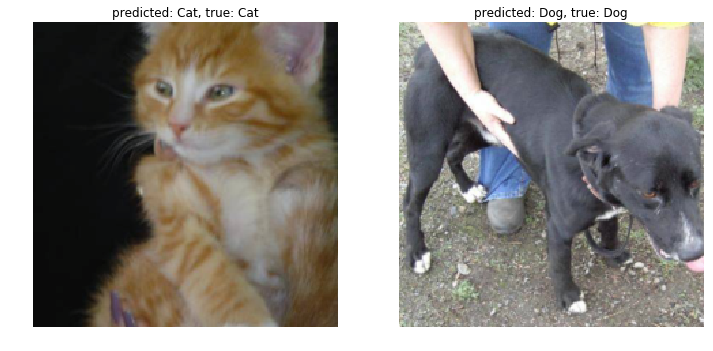

In [17]:
visualize_classify(model, dataloader=testloader, class_names=class_names,num_images=2)

### 1.5 Save model

In [18]:
# Save trained model
def save_checkpoint(filename, model, intermediate_size, output_size):
    checkpoint = {'intermediate_size': intermediate_size,
                  'output_size': output_size,
                  'state_dict': model.state_dict()}
    torch.save(checkpoint, filename)

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    # Load DenseNet
    model = models.densenet121(pretrained=True)    
    # Freeze parameters of the pre-trained network so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    # Define our own last classifier layers
    # Our inputs must match with the ones in the pre-trained network (in_features)
    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(1024, checkpoint['intermediate_size'])),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(checkpoint['intermediate_size'], checkpoint['output_size'])),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
    # Replace classifier
    model.classifier = classifier    
    # Overwrite weights & biases
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

In [19]:
# Save model
MODELPATH = './densenet121_trained_cat_dog.pth'
#intermediate_size = 500
#output_size = 2
save_checkpoint(MODELPATH, model, intermediate_size, output_size)
# Check that the model loads correctly
model = load_checkpoint(MODELPATH)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## 2. Inference

Once we have trained the model and it is saved, we can load it and infer new images. In this example, images from `../data/cat_dog_small/validation` will be used (which points to `../all`), although we usually carry out the inference on a new dataset without annotations/labels. The inference result can be collected in an Excel/CSV table.

Thus, if the `validation` folder is not there, just create it as follows:
```bash
cd ../data/cat_dog_small/
mkdir validation
cp -r all validation/
```

In [20]:
# Various modules: OpenCV, organize_dataset, matplotlib, utils
import cv2
import numpy as np
import organize_dataset
from matplotlib import pyplot as plt
import os
import random
import math
import pandas as pd
# PyTorch modules: Deep Learning
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
# Pre-trained networks are in models
from torchvision import datasets, transforms, models

### 2.1 Load model
It must have the same definition parameters (backbone network, classificator type and sizes, etc.) as during traning.

In [21]:
# Load model
model = load_checkpoint(MODELPATH)
# Define device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print('Device: {}'.format(device))

Device: cpu


### 2.2 Prepare validation dataset
It must be pre-processed in the same manner as the training/testing dataset.

In [22]:
class_names = ['Cat', 'Dog']

In [23]:
imagefiles = []
validationpath = '../data/cat_dog_small/validation'
for (dirpath, dirnames, filenames) in os.walk(validationpath+'/all'):
    imagefiles.extend(filenames)
    break

In [24]:
len(imagefiles)

50

Image number 27
Image shape: (374, 500, 3)


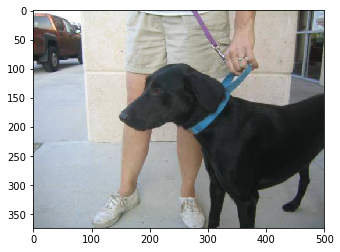

In [25]:
# Visualize images from the new validation dataset
#index = 2
index = math.ceil(random.random()*len(imagefiles))
image = cv2.imread(validationpath + '/all/' + imagefiles[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print('Image number {}'.format(index))
print('Image shape: {}'.format(image.shape))

In [26]:
# Create the validation dataset loader with all the transforms necessary
# We use NO DATA AUGMENTATION here, but any resizing & normalization must be carried out as in the training!
validation_transforms = transforms.Compose([ transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
validation_data = datasets.ImageFolder(validationpath, transform=validation_transforms)
# Important: batch size 1, no shuffling
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=1, shuffle=False)

### 2.3 Inference

In [27]:
def infer_images(model,
                 dataloader,
                 class_names,
                 num_images=-1,
                 display=False):

    model.to(device)
    num_images_dataset = len(dataloader.dataset)
    if num_images > num_images_dataset or num_images < 0:
        num_images = num_images_dataset        
    rows = list(range(num_images))
    columns = class_names
    n_rows = len(rows)
    n_columns = len(columns)
    data = np.zeros((n_rows,n_columns))
    df = pd.DataFrame(data,columns=columns)
    Filenames = []
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Filename
            sample_filename, _ = dataloader.dataset.samples[i]
            filename = os.path.basename(sample_filename)
            # Inference
            outputs = model.forward(inputs)
            _, preds = torch.max(outputs.data, dim=1)
            # If we have several classes, this part must be modified
            prediction = int(preds.item())
            class_values = [0, 0]
            if (prediction == 1):
                class_values = [0, 1]
            else:
                class_values = [1, 0]
            # Print
            if display:
                print(filename, class_values)
            # Save to dataframe
            Filenames.append(filename)
            df[class_names[0]][i] = class_values[0]
            df[class_names[1]][i] = class_values[1]
            if i == num_images - 1:
                break
    return (df,Filenames)

In [28]:
num_images = len(validationloader.dataset)
num_images

50

In [29]:
df,Filenames = infer_images(model,
                 dataloader=validationloader,
                 class_names=class_names,
                 num_images=-1,
                 display=False)

In [30]:
df.insert(0, 'Filenames', Filenames, True)

In [31]:
df

,Filenames,Cat,Dog
0,cat.114.jpg,1.0,0.0
1,cat.125.jpg,1.0,0.0
2,cat.134.jpg,1.0,0.0
3,cat.140.jpg,1.0,0.0
4,cat.143.jpg,1.0,0.0
5,cat.153.jpg,1.0,0.0
6,cat.159.jpg,1.0,0.0
7,cat.16.jpg,1.0,0.0
8,cat.160.jpg,1.0,0.0
9,cat.163.jpg,1.0,0.0


### 2.4 Save inference results

In [32]:
# Save to file
df.to_csv('inference_results.csv')